##  Pytorch geometric

Pytorch geometric is a pytorch package to train Graph Neural Networks.

One "simple" architecture is the Graph Convolutional Network (kipf et al)

references:
- http://tkipf.github.io/graph-convolutional-networks/
- https://proceedings.neurips.cc/paper/2015/hash/f9be311e65d81a9ad8150a60844bb94c-Abstract.html
- https://arxiv.org/abs/1609.02907


Install pytorch geometric : https://pytorch-geometric.readthedocs.io/en/latest/

In [1]:
! pip install torch_geometric rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 35.3 MB/s eta 0:00:0000:0100:01
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=993c7bd4bf5b460c76896d4a9d6c52bd9e55a2b9bc6d5e64e55ff3c554e76b4c
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


Simple graphs are manipulated with the torch_geometric.data.Data class : https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data

The constructor takes a collection a tensor representing the nodes and a tensor representing the edges.

Edges are represented by a 2D tensor (cf example here : https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html) where each columns represents an edge.


Create a simple undirected Graph with three nodes where node 1 is connected to node 2 and 3.
Specify the node values to be 1, 2, 3

In [2]:
import torch
from torch_geometric.data  import Data
import rdkit
from rdkit.Chem import MolFromSmiles, Draw
import networkx as nx
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


In [3]:
! [ -e outputs ] || mkdir outputs

In [4]:
OUPTUT_DIR_PATH = 'outputs'

In [5]:
to_output = lambda file_path : os.path.join(OUPTUT_DIR_PATH,file_path)

In [6]:
nodes = torch.arange(1,4)
edges = torch.zeros((2,2))
edges[0][0] = 1 
edges[0][1] = 2
edges[1][0] = 1 
edges[1][1] = 3
first_graph = Data(nodes,edges)
first_graph.to_dict()

{'x': tensor([1, 2, 3]),
 'edge_index': tensor([[1., 2.],
         [1., 3.]])}

# 1. Explore dataset in Pytorch_geometric


To better understand molecule and graph, we will load and explore one of the molecule datasets that come from the pytorch_geometric library.

**1. Load the HIV dataset from the torch_geometric.datasets.MoleculeNet module.**

In [7]:
molecule_net = MoleculeNet(root='.',name='HIV')

Processing...
Done!



**2. How many graphs are there in this dataset ? Print out the number of features and the number of classes for this dataset.**

In [8]:
graph_number = len(molecule_net)
print(f'There are {graph_number} graphs in the dataset')

There are 41127 graphs in the dataset


**3. Get the first graph in this dataset. Print out the number of nodes, the number of edges, the number of features and  the adjency matrix of this graph. This graph is undirected or not ?**

In [9]:
first_graph = molecule_net.get(0)
n_nodes = first_graph.num_nodes
n_edges = first_graph.num_edges
n_features = first_graph.num_features
adj_matrix = to_dense_adj(first_graph.edge_index)
print(f"{n_nodes = }")
print(f"{n_edges = }")
print(f"{n_features = }")
print(f"{adj_matrix = }")


n_nodes = 19
n_edges = 40
n_features = 9
adj_matrix = tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 1.],
         [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

**4. Draw this graph using networkx (it's already installed with pytorch_geometric) and torch_geometric.utils.to_networkx.**


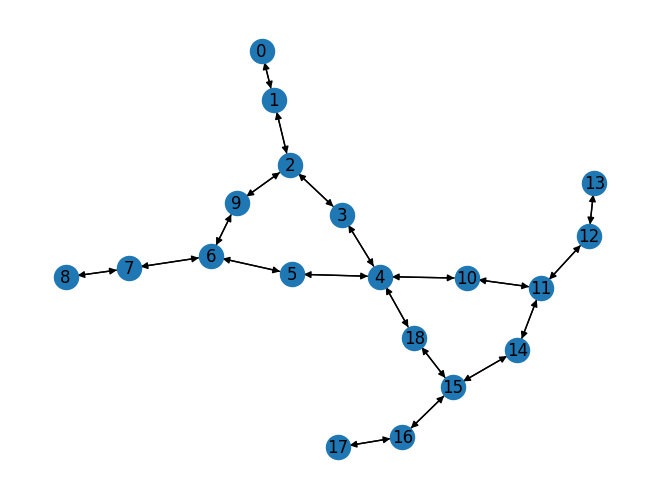

In [10]:
nx.draw(to_networkx(first_graph),with_labels=True)

**5. (Optional) Get the SMILES string of this molecule and draw its structure with Rdkit. The structure of this molecule looks like the graph that you've drawn in 4. ?**

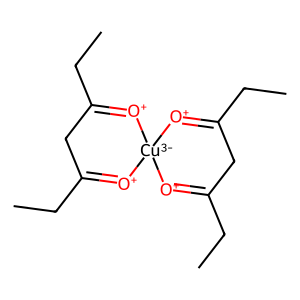

In [11]:
smiles = first_graph['smiles']
Draw.MolToImage(MolFromSmiles(smiles))

# EX 2. Convert a molecule to graph

A single graph in PyTorch Geometric is described by an instance of the torch_geometric.data.Data class. So, in order to use graph neural network in pytorch_geometric,  we need convert molecules to torch_geometric.data.Data object.


The **mol2graph(mol, y, smiles)** function below allows us to convert a molecule (rdkit format) to graph (a torch_geometric.data.Data object).


Just load the tab

In [12]:
x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}




e_map = {
    'bond_type': [
        'misc',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'is_conjugated': [False, True],
}

In [13]:
x_map.keys()

dict_keys(['atomic_num', 'chirality', 'degree', 'formal_charge', 'num_hs', 'num_radical_electrons', 'hybridization', 'is_aromatic', 'is_in_ring'])

In [14]:
def mol2graph(mol, y, smiles):

    
    xs = []

    for atom in mol.GetAtoms():

        x = []

        x.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
        # The atomic number is the number of protons in the nucleus of an atom

        x.append(x_map['chirality'].index(str(atom.GetChiralTag())))

        x.append(x_map['degree'].index(atom.GetTotalDegree()))
        # the number of carbon atoms that this atom is attached to

        x.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
        x.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
        x.append(x_map['num_radical_electrons'].index(
            atom.GetNumRadicalElectrons()))
        x.append(x_map['hybridization'].index(str(atom.GetHybridization())))
        x.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
        x.append(x_map['is_in_ring'].index(atom.IsInRing()))

        xs.append(x)



    x = torch.tensor(xs, dtype=torch.float).view(-1, 9)

    #print("x", x)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map['bond_type'].index(str(bond.GetBondType())))
        e.append(e_map['stereo'].index(str(bond.GetStereo())))
        e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    # Sort indices.
    y = torch.tensor(y, dtype=torch.long)

    if edge_index.numel() > 0:
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y = y, smiles=smiles)

    return data

**1. Use this function to convert a acetic acid molecule to graph. This function takes three parametes as inputs: rdkit molecule (mol), label of graph (here molecule is active or not) (y) and SMILES string of molecule.  Known that the SMILES string of acetic acid is "CC(O)=O" and you can choose in this case the label y = 1.**

In [15]:
smiles_acetic_acid = "CC(O)=O"
mol = MolFromSmiles(smiles_acetic_acid)
y = 1
acetic_acid_graph = mol2graph(mol,y,smiles_acetic_acid)
acetic_acid_graph

Data(x=[4, 9], edge_index=[2, 6], edge_attr=[6, 3], y=1, smiles='CC(O)=O')

**2. How many features are there in the nodes ? What are they ? Print out the "edge_index" of the acetic acide graph.**

In [16]:
n_features = acetic_acid_graph.num_features
print(f'{n_features = }')
acetic_acid_graph

n_features = 9


Data(x=[4, 9], edge_index=[2, 6], edge_attr=[6, 3], y=1, smiles='CC(O)=O')

According to `mol_2_graph`'s code those features seems to refer of properties contained in `x_map` such as:

In [17]:
print(list(x_map.keys()))

['atomic_num', 'chirality', 'degree', 'formal_charge', 'num_hs', 'num_radical_electrons', 'hybridization', 'is_aromatic', 'is_in_ring']


# Buid a Graph Neural Network (GNN)

 In the next exercises of this notebook, we will try to build a graph network to predict the ability of molecules to inhibit a protein known as ERK2. For this purpose, we will use compounds that are derived from the DUD-E database.

# Ex 3: Create dataset

The file named "active_data.csv" consists of more than 300 active and decoy molecules. The dataset is made of two components:

-  Chemical structural data on compounds: each chemical compound is described under the SMILES format.

-  ERK2-activity : it corresponds to the screening result evaluating the activity (1) or the inactivity (0) of the chemical compound.

**1. Read the "active_data.csv" file into a pandas dataframe. Are there how many active molecules and how many decoy molecules?**

In [18]:
active_data_path = os.path.join('/kaggle/input/active-data-2','active_data.csv')
active_df = pd.read_csv(active_data_path)
active_df.head()

,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [19]:
n_actives_mol = len(active_df[active_df['is_active'] == 1])
n_decoys_mol = len(active_df[active_df['is_active'] == 0])
print(f'{n_actives_mol } actives molecules')
print(f'{n_decoys_mol } decoys molecules')
print(f'{len(active_df)} total molecules')

79 actives molecules
300 decoys molecules
379 total molecules


**2. From this dataframe, create a list of RDKit molecules.**

In [20]:
molecules = list(map(MolFromSmiles,active_df['SMILES']))

**3. Using the mol2graph(mol, y, smiles) function to convert the list of Rdkit molecules to a list of torch_geometric.data.Data objects. You should call this list as "list_data".**

In [21]:
process_func = lambda active_data: mol2graph( MolFromSmiles(active_data['SMILES']) , active_data['is_active'], active_data['SMILES'])
list_data = list(map(process_func,active_df.iloc))

**4. Plot the histogram to see the ratio between the  compounds active and inactive.**

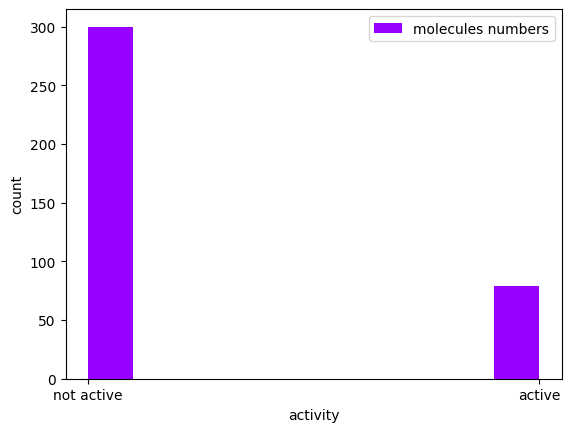

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts, bins = np.histogram(active_df['is_active'])
ax.set_xlabel('activity')
ax.set_ylabel('count')
uniques_val, counts = np.unique(active_df['is_active'],return_counts=True)
ax.hist(['not active','active'],weights=counts,label='molecules numbers',color=(0.6,0,1))
ax.legend()
fig.savefig(to_output('active_mol_hist.png'))
plt.show()


# EX 4. Create training set and test set
In this exercise, we will prepare a training set and a test set.

**1. Shuffle the "list_data" list that you've created above.**

In [23]:
random.seed(123)
random.shuffle(list_data)

**2. Take the first 300 molecules for "train_dataset" and the rest for "test_dataset".**

In [24]:
train_dataset = list_data[:300]
test_dataset = list_data[300:]

# Ex5: Create DataLoader

Usually a graph classification task trains on a lot of graphs, and it will be very inefficient to use only one graph at a time when training the model.

Pytorch Geometric opts for building a single giant graph from a list of graphs by stacking adjacency matrices in a diagonal fashion and node that target features are simply concatenated in the note dimension.

A single giant graph is automatically built from a list of graphs with DataLoader.

1. Create **train_loader** and **test_loader** from **train_dataset** and **test_dataset** by using the torch_geometric.data.DataLoader class.

In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader =DataLoader(test_dataset, batch_size=64, shuffle=True)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


2. Get a batch from **train_loader**. Print out the number of graphs and data of this batch.

In [26]:
batch = next(iter(train_loader))
print(f'There are {len(batch)} graphs in this batch')
batch

There are 64 graphs in this batch


DataBatch(x=[1567, 9], edge_index=[2, 3442], edge_attr=[3442, 3], y=[64], smiles=[64], batch=[1567], ptr=[65])

# Ex 6: Graph Neural Network Layer

 Let's try to test a graph neural network layer. This kind of layer is available on the pytorch_geometric.nn module. This layer's similar to Linear Layer (Multi-layer Perception Network) in deep learning.

In [27]:
smiles_acetic_acid = "CC(O)=O"
mol_acetic_acid = rdkit.Chem.MolFromSmiles(smiles_acetic_acid)
graph_acetic_acid = mol2graph(mol, y = 1, smiles = smiles_acetic_acid)

 **1. Create an instance of the torch_geometric.nn. GCNConv class. You need choose two parameters: number of features and number of hidden layers.**

In [28]:
gnn = GCNConv(in_channels=graph_acetic_acid.num_features,out_channels=16)

**2. Apply it to the graph of acetic acid.**

In [29]:
output = gnn(graph_acetic_acid.x,graph_acetic_acid.edge_index)
output

tensor([[-4.5495,  0.2681, -1.2580,  4.5701,  0.6843, -6.4962,  1.6610,  0.9795,
         -1.8745,  2.7851,  3.2033, -2.8319,  3.4328, -0.7249, -5.6189, -0.4558],
        [-7.6016, -0.3620, -3.0061,  7.4076,  1.9889, -9.6297,  3.6102,  2.5868,
         -2.7755,  3.6926,  5.7597, -4.7352,  4.8824, -0.6602, -7.9027, -1.7122],
        [-4.8103, -0.1822, -2.0000,  4.9605,  1.3312, -6.1043,  2.3275,  1.9952,
         -1.8370,  2.2183,  3.9569, -3.1488,  3.0264, -0.5369, -4.9337, -1.2528],
        [-4.8795, -0.3144, -2.3266,  4.8879,  1.6292, -5.7353,  2.5632,  2.2008,
         -1.7553,  1.9147,  4.0880, -3.1856,  2.8725, -0.4833, -4.5413, -1.4924]],
       grad_fn=<AddBackward0>)

**3. What is the output ? its size ?**

In [30]:
print(f'{output.size()}')

torch.Size([4, 16])


# EX 7: global_mean_pool Layer

As we've seen in the ex 6, the output of a GNN layer is a tensor with size (35, 16). However, for the graph classification task, the label of graph is just a scaler number. So, we need to aggregate node embeddings into a unified graph embedding (known as readout layer) before training a final classifier. Let's try it to see what the output of a global_mean_pool layer is.


1. Pass the **out_GCN_layer** variable to the global_mean_pool function. Store the result in a variable named **out_GMP_layer**

In [31]:

# GMP mean Global mean pool
data_for_test_GMP_layer = DataLoader([graph_acetic_acid], batch_size=1 )
conv_test = GCNConv(9, 16)


data = next(iter(data_for_test_GMP_layer))
out_GCN_layer = conv_test(data.x, data.edge_index)

#### TO DO #####

out_GMP_layer = global_mean_pool(out_GCN_layer,data.batch)

2. Print out the shape of `out_GMP_layer`.

In [32]:
print(out_GMP_layer)
print("shape of output_GMP_layer ", out_GMP_layer.size() )

tensor([[-2.7793, -0.8300,  2.6939, -3.7891,  0.3427, -4.7546, -2.9662,  0.4706,
         -3.3748,  3.5130, -4.4710, -2.6149, -3.1806, -3.7179, -2.0421, -1.5308]],
       grad_fn=<DivBackward0>)
shape of output_GMP_layer  torch.Size([1, 16])


# EX 8: Building a graph network for graph classification task with Pytorch geometric


In this exercise, we will create a network to classify if a molecule is active. This network consists of 4 layers:

1. A graph convolution network layer conv1

2. Another GCN layer conv2

3. Another GCN layer conv3

4. A torch_geometric.nn.global_mean_pool layer

5. A linear layer

Relu activation function is used after the two first layers.

Complete the lines below (after #TODO) to finish the definition of this network.

In [33]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

import torch
import torch.nn.functional as F
from torch.nn import Linear

#### TODO
n_features = 9



class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        torch.manual_seed(12)
        self.conv1 = GCNConv(n_features, 8)
        self.conv2 = GCNConv(8, 16)
        self.conv3 = GCNConv(16, 32)

        # TO DO
        self.linear = Linear(32, 2)


    def forward(self, x, edge_index, batch):


        # 1. Obtain node embeddings
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        ## TODO
        # Second GCN layer
        x =  self.conv2(x,edge_index)
        x =  F.relu(x)


        # Third GCN layer
        x = self.conv3(x, edge_index)


        ### TODO#####
        #2. REadout layer
        x = global_mean_pool(x,batch)


        # 3. Linear Layer
        ## TO DO
        x = self.linear(x)

        return x


# Ex 9: Create network


1. Create the network then print out the model and look at it's text representation

In [34]:
model = Net()

2. Define an optimizer. You should use the torch.optim.Adam class.

In [35]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

3. Define a loss function. You should use the CrossEntropyLoss class.

In [36]:
from torch.nn import CrossEntropyLoss
loss_func = CrossEntropyLoss()

In [37]:
print( model)

Net(
  (conv1): GCNConv(9, 8)
  (conv2): GCNConv(8, 16)
  (conv3): GCNConv(16, 32)
  (linear): Linear(in_features=32, out_features=2, bias=True)
)


# Ex 10: Train model for an epoch

Write a function named **train()** that allows us to train a model for an epoch.

The tasks that the function should execute:


0. Iterate in batches over the train_loader

1. Perform a single forward pass

2. Compute the loss

3. Derive the gradient

4. Update parameters

5. Clearn gradients



Complete the lines (with ?????) below to finish the function.

In [38]:
def train(loader, model, optimizer, loss_func):
    model.train()
    for data in loader:
        # 1. Forward pass
        out = model(data.x, data.edge_index, data.batch)
        
        # 2. Compute the loss
        loss = loss_func(out, data.y)
        
        # 3. Calculate the gradient
        loss.backward()
        
        # 4. Update the parameters (weights)
        optimizer.step()
        
        # 5. Clean gradients
        optimizer.zero_grad()

# Ex 11: Test

Similar to Ex9, write a function named **tes(loader)** that allows to compute the accuracy of the model on dataset "loader".

The steps to calculate the accuracy of a classification model:

1. Iterate in batches over the train_loader.

2. Compute the output of the model

3. Find the class with highest probability

4. Count ground-truth labels

5. Compute the accuracy


Complete the lines (with ?????)  to finish the definition of this network.

In [39]:
def test(loader,model):
    model.eval()
    correct = 0
    for data in loader:
        # output of the model
        out =  model(data.x,data.edge_index,data.batch)
        # Use the class with highest probability
        pred = out.argmax(dim=1)
        

        # Check against ground-truth labels
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

# Ex 12: Training model

Training model for 100 epoches.

Calculate training accuracy for train_loader and test_loader by using the **train()** function and the **test(loader)** function


In [40]:
from tqdm import tqdm
epochs = 100
model = Net()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_func = CrossEntropyLoss()
print(model)
train_accs = []
test_accs = []
for epoch in (range(1,epochs+1)):
    train(train_loader,model,optimizer,loss_func)
    train_acc = test(train_loader,model)
    test_acc =test(test_loader,model)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    
    # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
history_df = pd.DataFrame({'train_accuracy':train_accs,'test_accuracy':test_accs})
history_df.to_csv(to_output('history.csv'))


Net(
  (conv1): GCNConv(9, 8)
  (conv2): GCNConv(8, 16)
  (conv3): GCNConv(16, 32)
  (linear): Linear(in_features=32, out_features=2, bias=True)
)


In [41]:
test(test_loader,model)

0.759493670886076

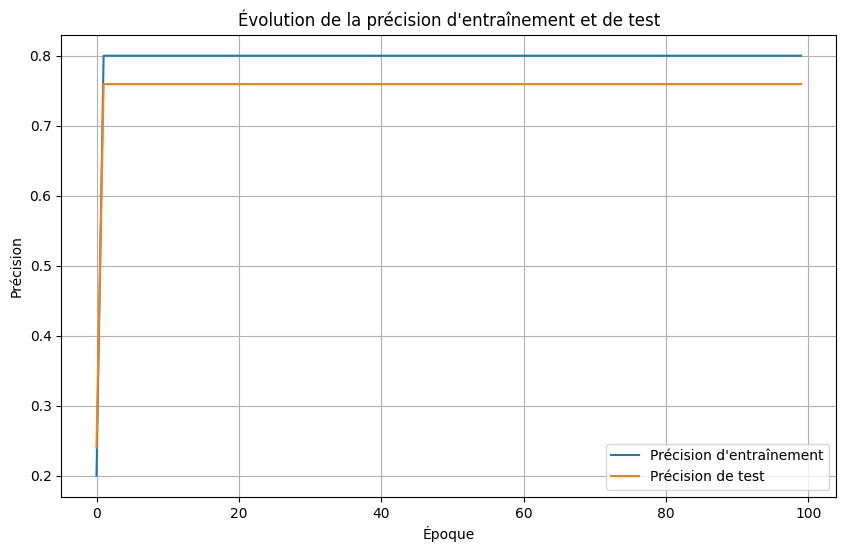

In [43]:
fig = plt.figure(figsize=(10, 6))  # Vous pouvez ajuster la taille de la figure selon vos préférences
fig.set_facecolor('white')
ax = fig.add_subplot(111)
ax.plot(history_df['train_accuracy'], label='Précision d\'entraînement')
ax.plot(history_df['test_accuracy'], label='Précision de test')
ax.set_xlabel('Époque')
ax.set_ylabel('Précision')
ax.legend()
ax.set_title('Évolution de la précision d\'entraînement et de test')
ax.grid(True)
fig.savefig(to_output('history.png'))
plt.show()